In [24]:
# General comments when using this skyfield package:
#
#- baricentric: barycentric = earth.at(t) or dws.at(t)
#  position of earth center or dws or any other point in space measured from the Solar System’s center of mass (without any corrections)
#- astrometric = barycentric.observe(moon)
#  when you use astrometric you can observe moon from earth center or dws at time t,
#  it applies the effect of light travel time.
#  i.e, on Earth we see the Moon where it was about 1.3 seconds ago, the Sun where it was 8 minutes ago.
#  Recently, it has been confirmed that "gravity" (according to Einstein) travel at the speed of light,
#  so if the sun "disappears" we will still feel gravity as waves arriving during 8 minutes, read:
#  https://www.forbes.com/sites/startswithabang/2020/12/18/ask-ethan-why-doesnt-gravity-happen-instantly/?sh=343391f17fd2
#- apparent = astrometric.apparent()
#  correct aberration of light produced by the observer’s own motion through space, and the gravitational deflection
#  light that passes close to masses like the Sun and Jupiter — and, for an observer on the Earth’s surface, for deflection produced by the Earth’s own gravity.
#  These corrections seem to be important when looking into the space to find an object, but not
#  for the gravitational effects on tides; however, the only way to get azimuth and altitude in this package is using .apparent()
#- altitude,azimuth = apparent.altaz()
#  get altitude and azimuth, can only be called with .apparent()

#Tutorials:
#https://rhodesmill.org/skyfield/positions.html#quick-reference
#
#https://rhodesmill.org/skyfield/time.html#downloading-timescale-files
#https://rhodesmill.org/skyfield/api-time.html#calendar-date
#https://rhodesmill.org/skyfield/example-plots.html
#https://rhodesmill.org/skyfield/positions.html
#https://rhodesmill.org/skyfield/

from skyfield.api import load
from skyfield.api import N, S, W, E, wgs84
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr
import dask as da
import pandas as pd
import scipy.fftpack as fftt #just for checking peaks of signals
import datetime 

In [2]:
#Average and std every M2----
#
#Conclusion 
#Using data every integer M2=44714s, or average-M2, or starting from different initial time: 
# - induce a long term lag in the 36-years data of 1.3h in comparison with the more accurate M2 (44714.16432s) that dont.
# - the effect of the appox integer M2 on the angular positions and distance depends when you start and on the avg.
# - it is supposed this is a real effect in our simulation, as we deployed particles every integer M2.
#Data to be used:
# - mean and std of position and distances, as well as the initial values at the begin of the interval

In [64]:
#----------
home_dir="/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_displacement="net_displacement/"
#
m2=int(12.42*3600+2) #period in seconds
dt_fac_m2_sec=283*2 #get astronomical data every 566s = 9.43 min (factor of m2=44714)
#
#paths for output data
dir_post_proc_data=f"{ml_dir}post_proc_data/" #to save wind interp files
dir_tides_skyfield="tides_skyfield/"
file_tides_skyfield="skyfield_distance_azimuth_altitude_every_avg_std_M2_moon_sun_from_dws_for_convlstm.nc"

In [4]:
#get time from net displacement files---
files_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}*.nc',recursive=True))
#concat all the files
dsdis=xr.open_mfdataset(files_displacement,concat_dim="time",combine='nested',parallel='True',chunks={'time': -1},
                        decode_cf=True, decode_times=True)
time_dis=dsdis.time.values
dsdis.close(); del dsdis
#
nt_dis=len(time_dis) #=25290 deployments
#
#times to get astronomical info and then perform std and avg in the m2 interval---
tini=time_dis[0]; tinip=pd.to_datetime(tini)
tend=time_dis[-1]+np.timedelta64(m2-dt_fac_m2_sec,'s'); tendp=pd.to_datetime(tend) #1 extra m2 to have the full interval for the last deployment but without the last point
dt=dt_fac_m2_sec/86400 #dt_fac_m2_sec = 566s = 9.43 min (factor of m2=44714)
print("deployments = ",nt_dis)

deployments =  25290


In [5]:
#Create a skyfield timescale---
ts = load.timescale()

In [6]:
#Load the JPL ephemeris DE421 (covers 1900-2050)---
#An ephemeris from the JPL provides Sun, Moon, planets and Earth positions.
eph = load('de421.bsp')
earth, moon, sun = eph['earth'], eph['moon'], eph['sun']

In [25]:
#create a time vector with skyfield--- 

#find total seconds between init and final date:
ti=datetime.datetime(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
te=datetime.datetime(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
tot_sec=(te-ti).total_seconds() #total elapsed seconds
#
#build Time objects from an UTC calendar date, using the init UTC date and the elapsed seconds since this initial date
time=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,dt_fac_m2_sec))
dtt=np.diff(time.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,time.shape)
#
#check the first 2 and the last 2 times of the vector built with skynet
#there are 17 leap seconds from 1980-2015 (for us and accord to wikipedia), but it does not matter since after referencing the first date, then it is only used the elapsed time
#we have the same time difference (elapsed time in seconds) for:
# - tot_sec = dt_fac_m2_sec*(len(time)-1) = the actual elapsed seconds
# - time[-1].tt-time[0].tt)*86400
# - np.sum(np.diff(time.tt))*86400
# - and also assuming that the init and final dates are in a TT calendar (which is not ok since they are in a UTC calendar)
print(tinip,time[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,time[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(time.tt))*86400,(time[-1].tt-time[0].tt)*86400,tot_sec,dt_fac_m2_sec*(len(time)-1)
print()

#using numpy (it does not take into account leap seconds), but the size of the array is the same as skyfield
#the elapsed time is also the same
time_np=np.arange(tini,tend+np.timedelta64(1,'s'),dt_fac_m2_sec,dtype='datetime64[s]') 
print(time_np,time_np.shape)

566 565.9999877214432 565.9999999999953 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 08:29:26']
2015-11-01 12:01:34 ['2015-11-01 11:51:51', '2015-11-01 12:01:17']

['1980-01-01T08:20:00' '1980-01-01T08:29:26' '1980-01-01T08:38:52' ...
 '2015-11-01T11:42:42' '2015-11-01T11:52:08' '2015-11-01T12:01:34'] (1997910,)


In [26]:
#check time dimensions
nt_interval=int(m2/dt_fac_m2_sec) #points in the m2 interval (right border of interval open)
nt_dep=len(time_np)//nt_interval #=len(t_dep), final shape after mean or std in the m2 interval. 
nt_interval,nt_dep,nt_dis,nt_interval*nt_dep

(79, 25290, 25290, 1997910)

In [27]:
#Computations in Topocentric coordinates-----
#
#specific to your location on the Earth’s surface
lat=53.0; lon=4.5 #in front of Texel
dws = earth + wgs84.latlon(lat*N,lon*E) 

### Moon

In [10]:
%%time
#MOON----
#3.5minutes from 1980-2016
astro_moon = dws.at(time).observe(moon)
#- altitude or elevation (deg,min,sec): -90:90deg
#- azimuth (deg,min,sec): 0:360deg
#- distance (au or km): 1au (astronomical unit) = 1.496e8km
alt_moon, az_moon, dist_moon = astro_moon.apparent().altaz()
print(alt_moon)
print(az_moon)
#print(dist_moon)
#
#convert above values to arrays---
#altitude_moon_rad=alt_moon.radians
altitude_moon_deg=alt_moon.degrees
#azimuth_moon_rad=alt_moon.radians
azimuth_moon_deg=az_moon.degrees
distance_moon_au = dist_moon.au #AU units
#distance_moon_km = dist_moon.km #km units
#distance_moon_km2 = dist_moon2.km #km units
#a=distance_moon_km-distance_moon_km2 #almost the same distnace when using .radec
print(altitude_moon_deg[[0,-1]])
print(azimuth_moon_deg[[0,-1]])
print(distance_moon_au[[0,-1]])
#print(distance_moon_km[[0,-1]])

1997910 values from -11deg 54' 44.2" to -03deg 19' 32.1"
1997910 values from 323deg 38' 39.0" to 303deg 54' 07.9"
[-11.91226487  -3.32559382]
[323.64415874 303.90218954]
[0.00259017 0.00256895]
CPU times: user 5min 38s, sys: 52.9 s, total: 6min 31s
Wall time: 3min 30s


In [30]:
## circular mean and std of angles (without taking into account the magnitude of vector)
##https://en.wikipedia.org/wiki/Directional_statistics#The_fundamental_difference_between_linear_and_circular_statistics

def circ_mean_std(var,units="deg",axis=-1):
    
    if units=="deg":
        fac=np.pi/180.
    else:
        fac=1.
    var=var*fac
    
    #mean
    sin_mean = np.mean(np.sin(var),axis=axis); cos_mean = np.mean(np.cos(var),axis=axis)
    var_mean = np.arctan2(sin_mean,cos_mean) #=np.arctan2(y,x), y/x=tan(angle)
    #if type(var).__name__  == "ndarray": print("this is an array")
    
    #std
    var_std=np.minimum(1.,sin_mean**2+cos_mean**2) #to avoid round issues
    var_std=(-np.log(var_std))**.5
    
    if units=="deg":
        var_mean/=fac; var_std/=fac
    
    return var_mean, var_std

#and check with scipy
from scipy.stats import circmean,circstd

In [14]:
#reshape variables---
#(nt_dep,nt_interval)
distance_moon_au_re=np.reshape(distance_moon_au,(nt_dep,nt_interval))
altitude_moon_deg_re=np.reshape(altitude_moon_deg,(nt_dep,nt_interval))
azimuth_moon_deg_re=np.reshape(azimuth_moon_deg,(nt_dep,nt_interval))

#circular mean and std---
mean_distance_moon_au, std_distance_moon_au = np.mean(distance_moon_au_re,axis=-1), np.std(distance_moon_au_re,axis=-1)
mean_altitude_moon_deg, std_altitude_moon_deg = circ_mean_std(altitude_moon_deg_re)
mean_azimuth_moon_deg, std_azimuth_moon_deg = circ_mean_std(azimuth_moon_deg_re)

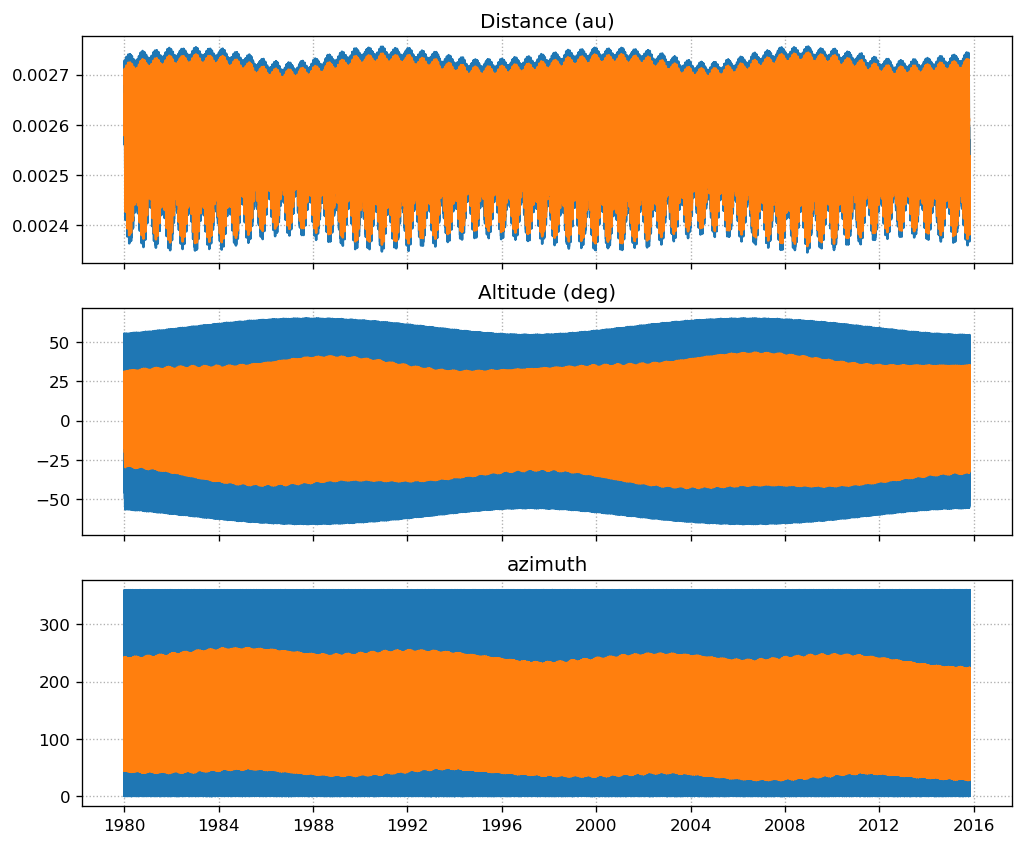

In [15]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(time_np,distance_moon_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_moon_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(time_np,altitude_moon_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_moon_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
#convert azimuth from 0:360
mean_azimuth_moon_deg2=mean_azimuth_moon_deg*1.
mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]=mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]+360
ax[2].plot(time_np,azimuth_moon_deg)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_moon_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(time_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

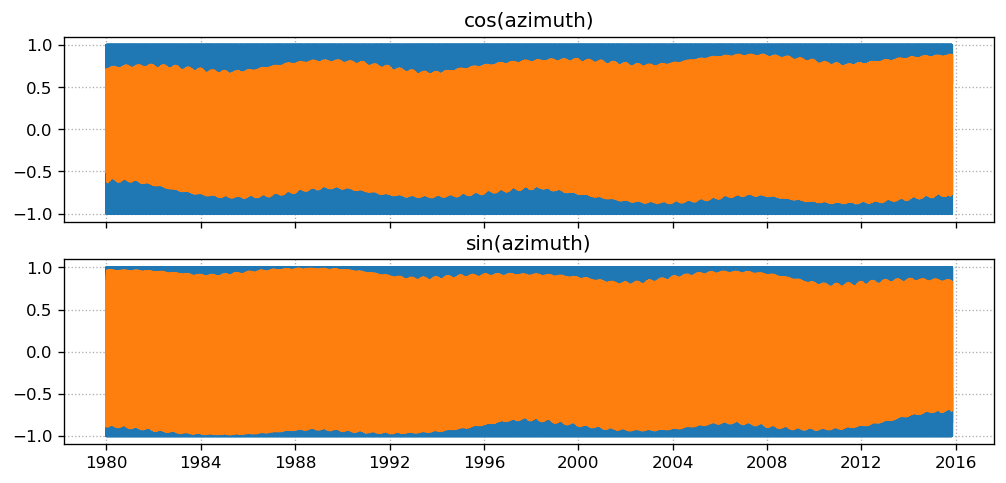

In [16]:
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(time_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),np.cos(mean_azimuth_moon_deg2/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(time_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),np.sin(mean_azimuth_moon_deg2/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

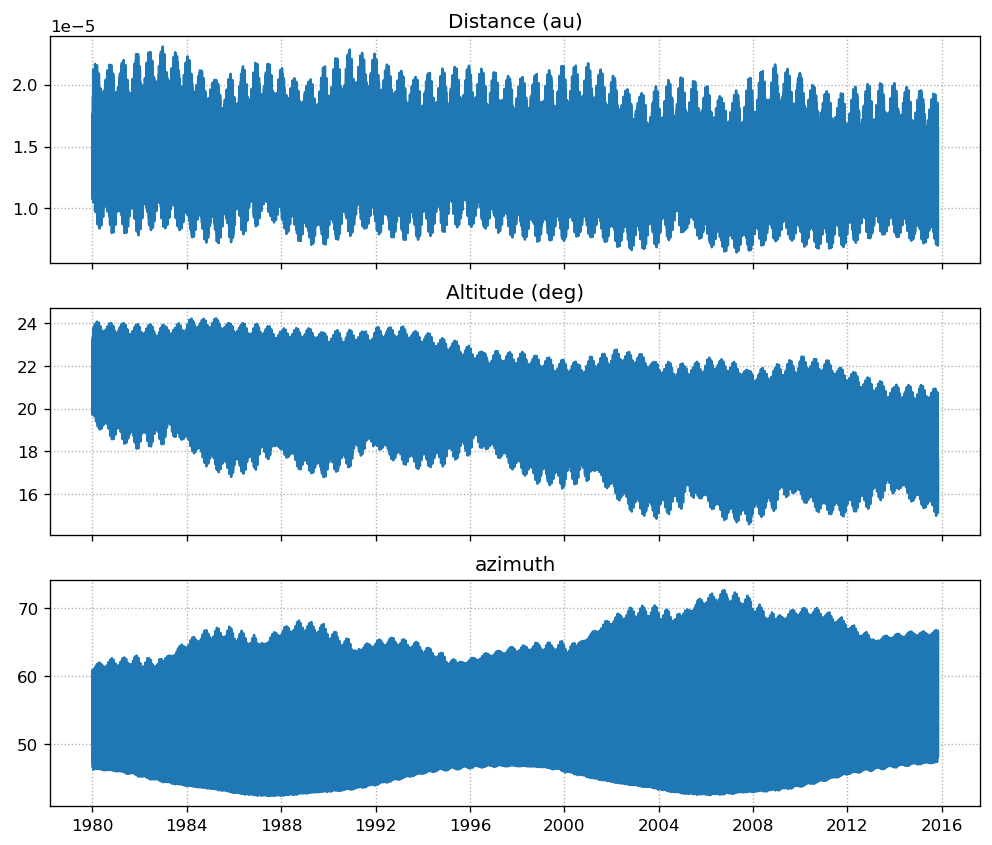

In [17]:
#std
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
#ax[0].plot(time_np,distance_moon_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),std_distance_moon_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
#ax[1].plot(time_np,altitude_moon_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),std_altitude_moon_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),std_azimuth_moon_deg)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(time_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

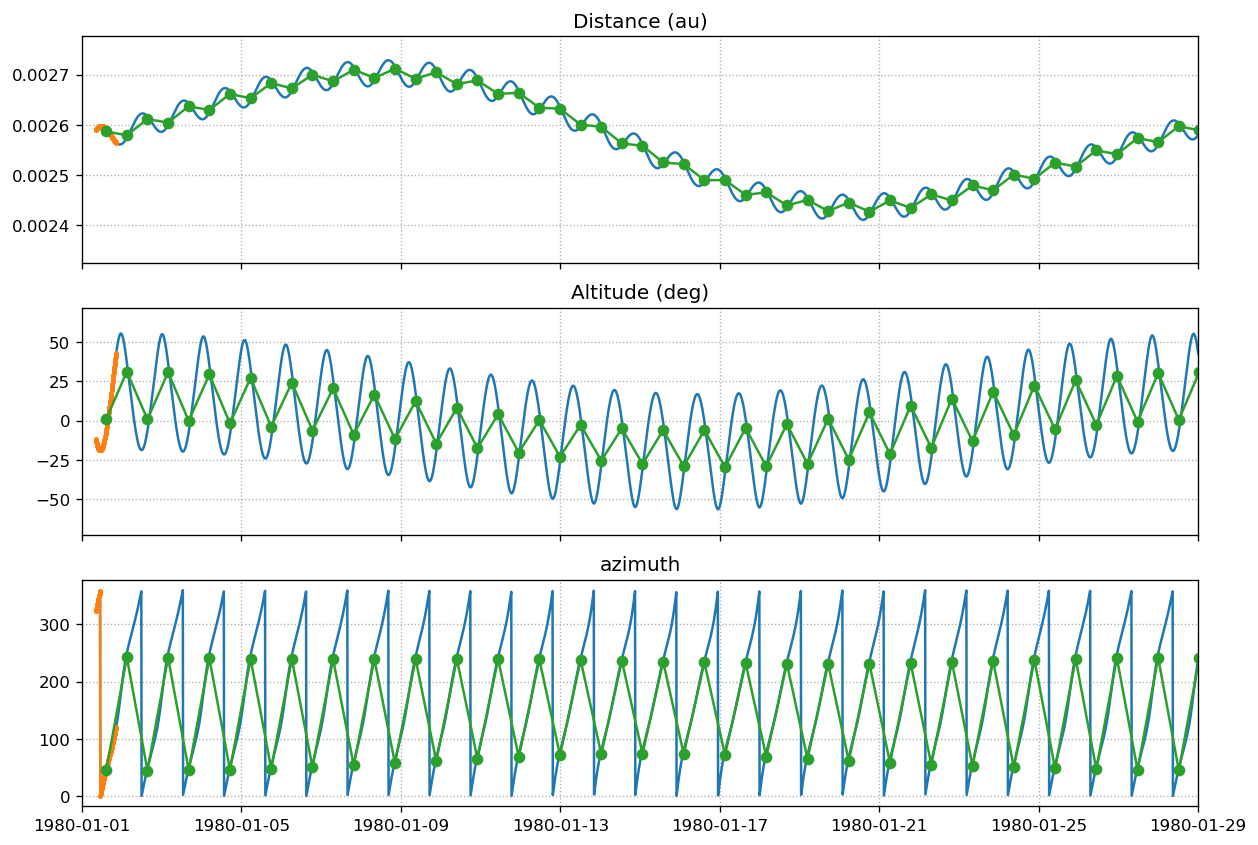

In [28]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(time_np,distance_moon_au)
ax[0].plot(time_np[:nt_interval],distance_moon_au[:nt_interval],"-o",ms=2)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_moon_au,"-o")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Altitude:
ax[1].plot(time_np,altitude_moon_deg)
ax[1].plot(time_np[:nt_interval],altitude_moon_deg[:nt_interval],"-o",ms=2)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_moon_deg,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
#convert azimuth from 0:360
mean_azimuth_moon_deg2=mean_azimuth_moon_deg*1.
mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]=mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]+360
ax[2].plot(time_np,azimuth_moon_deg)
ax[2].plot(time_np[:nt_interval],azimuth_moon_deg[:nt_interval],"-o",ms=2)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_moon_deg2,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(time_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### Sun

In [46]:
%%time
#SUN----
#3.5minutes from 1980-2016
astro_sun = dws.at(time).observe(sun)
#- altitude or elevation (deg,min,sec): -90:90deg
#- azimuth (deg,min,sec): 0:360deg
#- distance (au or km): 1au (astronomical unit) = 1.496e8km
alt_sun, az_sun, dist_sun = astro_sun.apparent().altaz()
print(alt_sun)
print(az_sun)
#print(dist_sun)
#
#convert above values to arrays---
#altitude_sun_rad=alt_sun.radians
altitude_sun_deg=alt_sun.degrees
#azimuth_sun_rad=alt_sun.radians
azimuth_sun_deg=az_sun.degrees
distance_sun_au = dist_sun.au #AU units
#distance_sun_km = dist_sun.km #km units
#distance_sun_km2 = dist_sun2.km #km units
#a=distance_sun_km-distance_sun_km2 #almost the same distnace when using .radec
print(altitude_sun_deg[[0,-1]])
print(azimuth_sun_deg[[0,-1]])
print(distance_sun_au[[0,-1]])
#print(distance_sun_km[[0,-1]])

1997910 values from 01deg 54' 53.1" to 22deg 08' 58.2"
1997910 values from 134deg 04' 23.5" to 189deg 20' 09.3"
[ 1.9147423  22.14950607]
[134.07320716 189.33591968]
[0.98327023 0.99253671]
CPU times: user 5min 30s, sys: 24.7 s, total: 5min 55s
Wall time: 3min 17s


In [47]:
#reshape variables---
#(nt_dep,nt_interval)
distance_sun_au_re=np.reshape(distance_sun_au,(nt_dep,nt_interval))
altitude_sun_deg_re=np.reshape(altitude_sun_deg,(nt_dep,nt_interval))
azimuth_sun_deg_re=np.reshape(azimuth_sun_deg,(nt_dep,nt_interval))

#mean and std
mean_distance_sun_au, std_distance_sun_au = np.mean(distance_sun_au_re,axis=-1), np.std(distance_sun_au_re,axis=-1)
mean_altitude_sun_deg, std_altitude_sun_deg = circ_mean_std(altitude_sun_deg_re)
mean_azimuth_sun_deg, std_azimuth_sun_deg = circ_mean_std(azimuth_sun_deg_re)

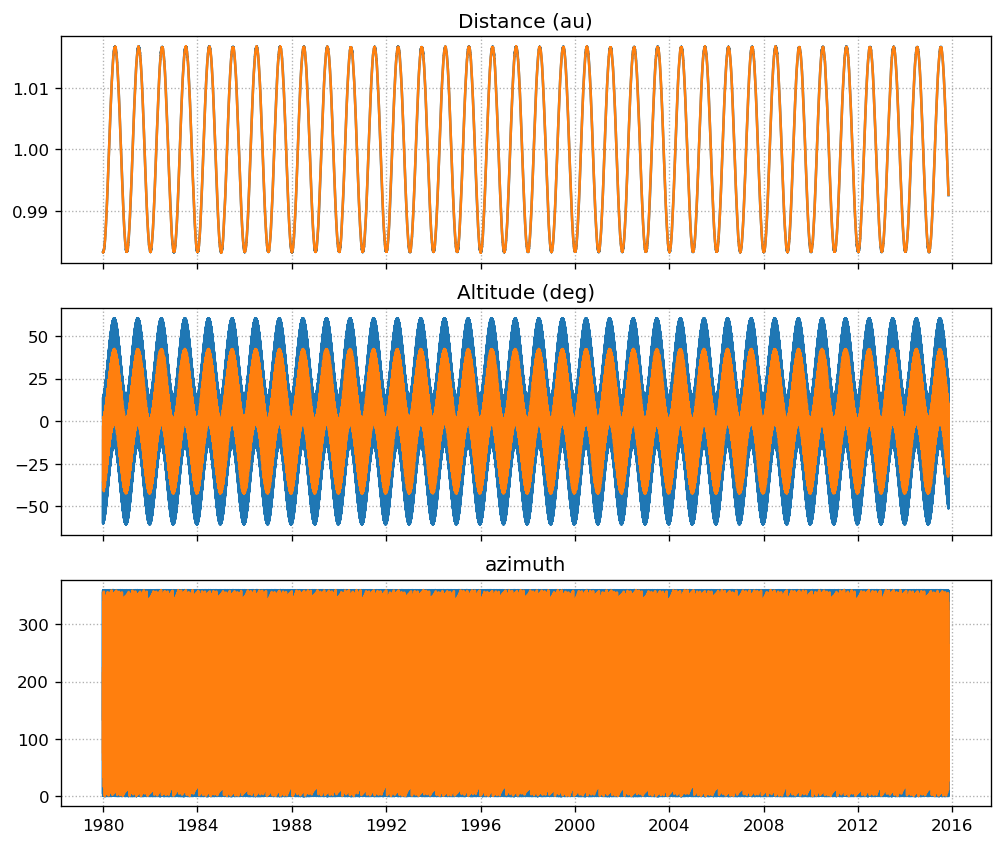

In [48]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(time_np,distance_sun_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_sun_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(time_np,altitude_sun_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_sun_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
#convert azimuth from 0:360
mean_azimuth_sun_deg2=mean_azimuth_sun_deg*1.
mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]=mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]+360
ax[2].plot(time_np,azimuth_sun_deg)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_sun_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(time_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

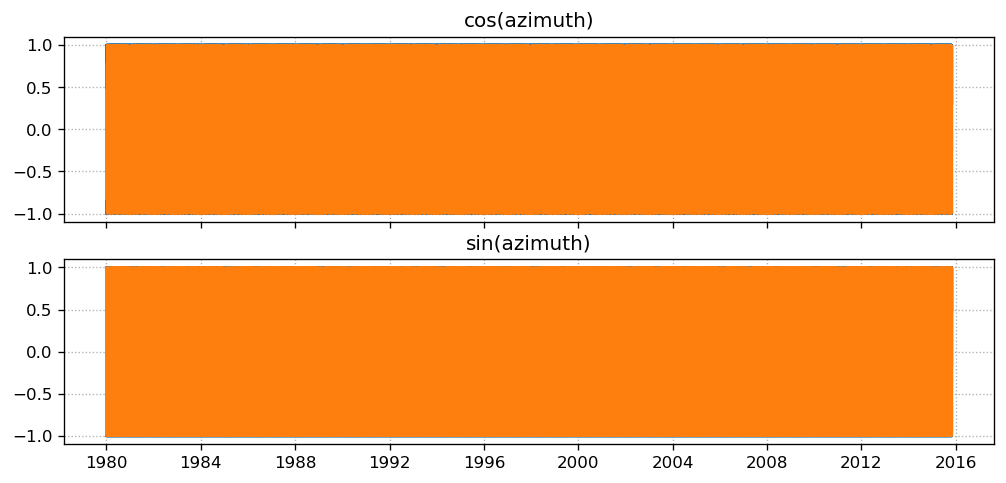

In [49]:
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(time_np,np.cos(azimuth_sun_deg/180*np.pi))
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),np.cos(mean_azimuth_sun_deg2/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(time_np,np.sin(azimuth_sun_deg/180*np.pi))
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),np.sin(mean_azimuth_sun_deg2/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

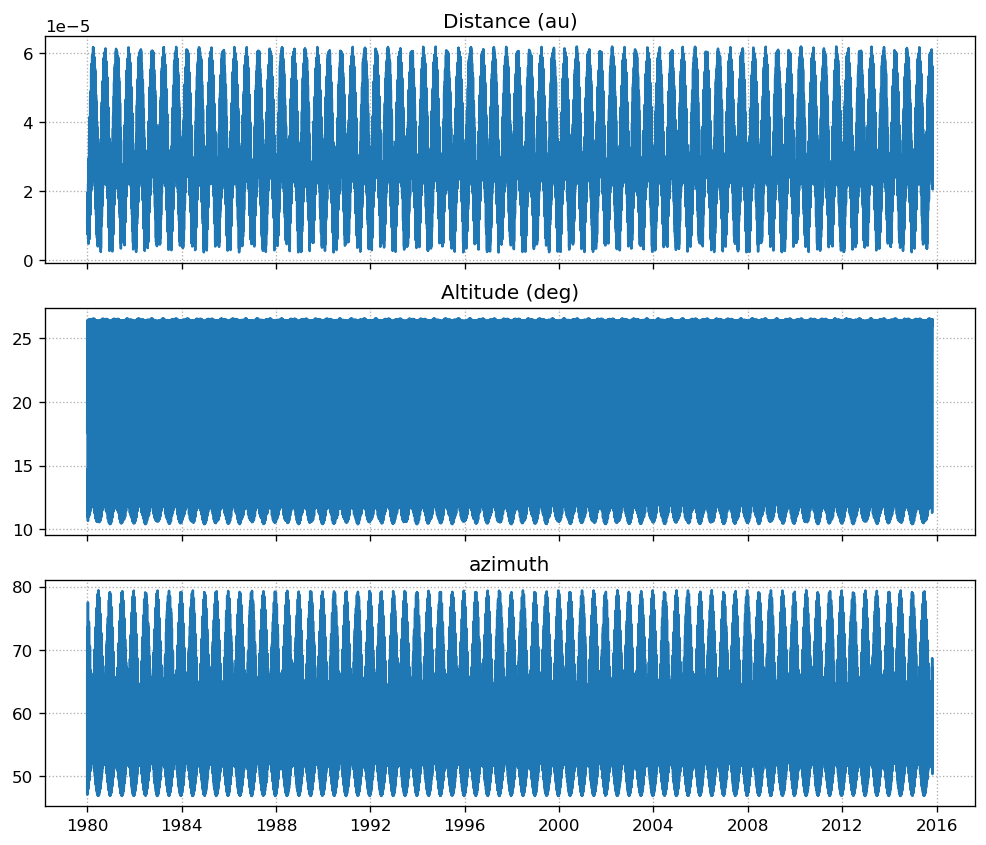

In [50]:
#std---
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
#ax[0].plot(time_np,distance_sun_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),std_distance_sun_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
#ax[1].plot(time_np,altitude_sun_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),std_altitude_sun_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),std_azimuth_sun_deg)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(time_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

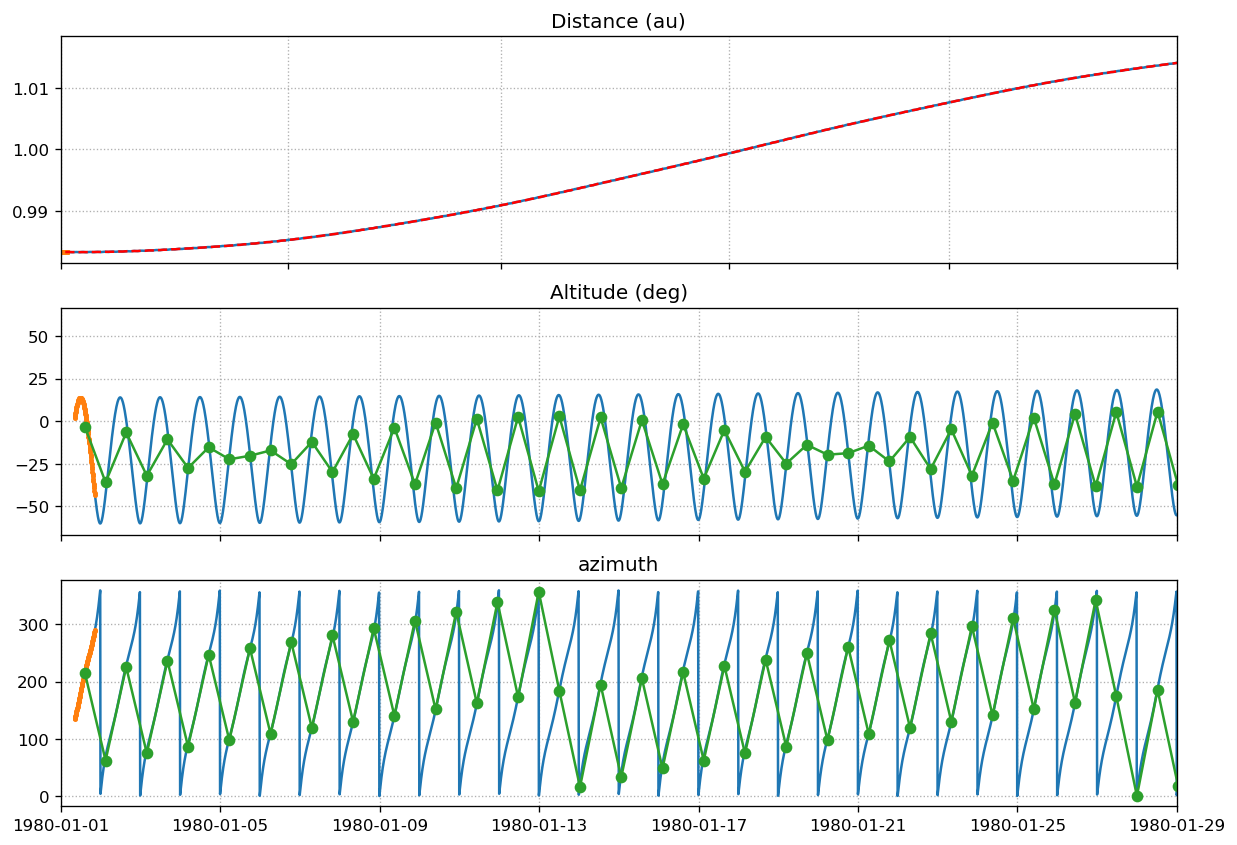

In [51]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(time_np,distance_sun_au)
ax[0].plot(time_np[:nt_interval],distance_sun_au[:nt_interval],"-o",ms=2)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_sun_au,'--',c='r')
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-06-01"))
#Altitude:
ax[1].plot(time_np,altitude_sun_deg)
ax[1].plot(time_np[:nt_interval],altitude_sun_deg[:nt_interval],"-o",ms=2)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_sun_deg,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
#convert azimuth from 0:360
mean_azimuth_sun_deg2=mean_azimuth_sun_deg*1.
mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]=mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]+360
ax[2].plot(time_np,azimuth_sun_deg)
ax[2].plot(time_np[:nt_interval],azimuth_sun_deg[:nt_interval],"-o",ms=2)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_sun_deg2,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(time_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### saving data

In [82]:
#save data---
dsout = xr.Dataset()
#global coords and attrs---
dsout.coords["time"] = time_dis
dsout["time"].attrs['description'] = 'initial date of the M2 interval of the net particle displacement'
dsout.attrs["angular_statistics"] = "mean and std of altitude and azimuth computed with circular statistics"
dsout.attrs["lon_lat_observation"] = f"{lon}E {lat}N"
dsout.attrs["skyfield_command_to_generate_variables"] = "alt,azi,dist = (earth + wgs84.latlon(lat*N,lon*E)).at(time).observe(moon or sun).apparent().altaz()"
#
#variables---
#
dsout["moon_dist_every_m2"] = (("time"),distance_moon_au[::nt_interval].astype("float32"))
dsout["moon_dist_every_m2"].attrs['long_name'] = 'moon distance every m2'
dsout["moon_dist_every_m2"].attrs['units'] = 'au (astronomical unit)'
#
dsout["moon_alt_every_m2"] = (("time"),(altitude_moon_deg[::nt_interval]*np.pi/180).astype("float32"))
dsout["moon_alt_every_m2"].attrs['long_name'] = 'moon altitude every m2'
dsout["moon_alt_every_m2"].attrs['units'] = 'radian'
#
dsout["moon_azi_every_m2"] = (("time"),(azimuth_moon_deg[::nt_interval]*np.pi/180).astype("float32"))
dsout["moon_azi_every_m2"].attrs['long_name'] = 'moon azimuth every m2'
dsout["moon_azi_every_m2"].attrs['units'] = 'radian'
#
dsout["moon_dist_mean"] = (("time"),mean_distance_moon_au.astype("float32"))
dsout["moon_dist_mean"].attrs['long_name'] = 'M2-mean moon distance'
dsout["moon_dist_mean"].attrs['units'] = 'au (astronomical unit)'
#
dsout["moon_alt_mean"] = (("time"),(mean_altitude_moon_deg*np.pi/180).astype("float32"))
dsout["moon_alt_mean"].attrs['long_name'] = 'M2-mean moon altitudeM2-mean '
dsout["moon_alt_mean"].attrs['units'] = 'radian'
#
dsout["moon_azi_mean"] = (("time"),(mean_azimuth_moon_deg*np.pi/180).astype("float32"))
dsout["moon_azi_mean"].attrs['long_name'] = 'M2-mean moon azimuth'
dsout["moon_azi_mean"].attrs['units'] = 'radian'
#
dsout["moon_dist_std"] = (("time"),std_distance_moon_au.astype("float32"))
dsout["moon_dist_std"].attrs['long_name'] = 'M2-std moon distance'
dsout["moon_dist_std"].attrs['units'] = 'au (astronomical unit)'
#
dsout["moon_alt_std"] = (("time"),(std_altitude_moon_deg*np.pi/180).astype("float32"))
dsout["moon_alt_std"].attrs['long_name'] = 'M2-std moon altitudeM2-std '
dsout["moon_alt_std"].attrs['units'] = 'radian'
#
dsout["moon_azi_std"] = (("time"),(std_azimuth_moon_deg*np.pi/180).astype("float32"))
dsout["moon_azi_std"].attrs['long_name'] = 'M2-std moon azimuth'
dsout["moon_azi_std"].attrs['units'] = 'radian'
#
dsout["sun_dist_every_m2"] = (("time"),distance_sun_au[::nt_interval].astype("float32"))
dsout["sun_dist_every_m2"].attrs['long_name'] = 'sun distance every m2'
dsout["sun_dist_every_m2"].attrs['units'] = 'au (astronomical unit)'
#
dsout["sun_alt_every_m2"] = (("time"),(altitude_sun_deg[::nt_interval]*np.pi/180).astype("float32"))
dsout["sun_alt_every_m2"].attrs['long_name'] = 'sun altitude every m2'
dsout["sun_alt_every_m2"].attrs['units'] = 'radian'
#
dsout["sun_azi_every_m2"] = (("time"),(azimuth_sun_deg[::nt_interval]*np.pi/180).astype("float32"))
dsout["sun_azi_every_m2"].attrs['long_name'] = 'sun azimuth every m2'
dsout["sun_azi_every_m2"].attrs['units'] = 'radian'
#
dsout["sun_dist_mean"] = (("time"),mean_distance_sun_au.astype("float32"))
dsout["sun_dist_mean"].attrs['long_name'] = 'M2-mean sun distance'
dsout["sun_dist_mean"].attrs['units'] = 'au (astronomical unit)'
#
dsout["sun_alt_mean"] = (("time"),(mean_altitude_sun_deg*np.pi/180).astype("float32"))
dsout["sun_alt_mean"].attrs['long_name'] = 'M2-mean sun altitudeM2-mean '
dsout["sun_alt_mean"].attrs['units'] = 'radian'
#
dsout["sun_azi_mean"] = (("time"),(mean_azimuth_sun_deg*np.pi/180).astype("float32"))
dsout["sun_azi_mean"].attrs['long_name'] = 'M2-mean sun azimuth'
dsout["sun_azi_mean"].attrs['units'] = 'radian'
#
dsout["sun_dist_std"] = (("time"),std_distance_sun_au.astype("float32"))
dsout["sun_dist_std"].attrs['long_name'] = 'M2-std sun distance'
dsout["sun_dist_std"].attrs['units'] = 'au (astronomical unit)'
#
dsout["sun_alt_std"] = (("time"),(std_altitude_sun_deg*np.pi/180).astype("float32"))
dsout["sun_alt_std"].attrs['long_name'] = 'M2-std sun altitudeM2-std '
dsout["sun_alt_std"].attrs['units'] = 'radian'
#
dsout["sun_azi_std"] = (("time"),(std_azimuth_sun_deg*np.pi/180).astype("float32"))
dsout["sun_azi_std"].attrs['long_name'] = 'M2-std sun azimuth'
dsout["sun_azi_std"].attrs['units'] = 'radian'
#
dsout.to_netcdf(dir_post_proc_data+dir_tides_skyfield+file_tides_skyfield)
dsout.close(); 
del dsout; 